# Machine learning, summary plots by fold

In [1]:
import functools
import numpy as np
import pandas as pd
from venn import venn
from collections import Counter
from scipy.stats import linregress
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from plotnine import *
from warnings import filterwarnings
from matplotlib.cbook import mplDeprecation

In [2]:
filterwarnings("ignore",category=mplDeprecation)
filterwarnings('ignore', category=UserWarning, module='plotnine.*')
filterwarnings('ignore', category=DeprecationWarning, module='plotnine.*')

In [3]:
def extract_ml(feature):
    ml_file = '../../_m/%s/autosomal_chrom/rank_features.txt' % feature
    ml_df = pd.read_csv(ml_file, sep='\t', header=None, names=['Names', 'Fold', 'rank'])
    ml = ml_df.pivot(index='Names', columns='Fold')
    ml['median'] = ml.median(axis=1)
    ml = ml.sort_values('median')
    ml['Geneid'] = ml.index
    ml['Rank'] = ml['median'].rank()
    return ml[['Geneid', 'Rank']]


In [4]:
@functools.lru_cache()
def get_residualized(fn):
    '''Load residualization file.
    '''
    return pd.read_csv(fn, sep='\t', index_col=0).transpose()


@functools.lru_cache()
def get_pheno_data():
    return pd.read_csv('/ceph/projects/v3_phase3_paper/inputs/phenotypes/_m/dlpfc_phenotypes.csv', 
                       index_col=0)

In [5]:
def get_deg_res_df(fn, df):
    res_df = get_residualized(fn)
    return res_df.loc[:, np.array(df.index)]


def cal_pca(df):
    x = StandardScaler().fit_transform(df)
    pca = PCA(n_components=2).fit_transform(x)
    return pd.DataFrame(data=pca, columns=['PC1', 'PC2'], index=df.index)


def get_explained_variance(df):
    x = StandardScaler().fit_transform(df)
    pca = PCA(n_components=2).fit(x)
    pc1 = pca.explained_variance_ratio_[0]
    pc2 = pca.explained_variance_ratio_[1]
    print("Explained Variance\nPC1:\t%0.5f\nPC2:\t%0.5f" % (pc1, pc2))
    

In [6]:
def get_pca_df(fn, df):
    '''
    num: refers to how many genes we want to include
    if 0, look at all genes, if not 0, look at only those specified genes
    new_pheno: this is the correct size of samples using the the first two columns of residualized expression
      - the residualized expression data frame, has the correct samples (dropping qSV samples included in pheno)
      - output new_pheno shape row numbers should be the same as res_df row numbers
    '''
    expr_res = get_deg_res_df(fn, df)
    pheno_df = get_pheno_data()
    new_pheno = pheno_df.merge(expr_res.iloc[:, 0:1], right_index=True, # Generate pheno data frame with correct samples
                               left_index=True).drop(expr_res.iloc[:, 0:1].columns, axis=1)
    principalDf = cal_pca(expr_res)
    get_explained_variance(expr_res)
    return pd.concat([principalDf, new_pheno], axis = 1)


def calculate_corr(xx, yy):
    '''This calculates R^2 correlation via linear regression:
         - used to calculate relationship between 2 arrays 
         - the arrays are principal components 1 or 2 (PC1, PC2) AND gender
         - calculated on a scale of 0 to 1 (with 0 being no correlation)
        Inputs: 
          x: array of Gender (converted to binary output)
          y: array of PC
        Outputs: 
          1. r2
          2. p-value, two-sided test 
            - whose null hypothesis is that two sets of data are uncorrelated
          3. slope (beta): directory of correlations
    '''
    slope, intercept, r_value, p_value, std_err = linregress(xx, yy)
    return slope, r_value, p_value

    
def corr_annotation(dft):
    xx = dft.Sex.cat.codes
    yy = dft.PC1
    zz = dft.PC2
    slope1, r_value1, p_value1 = calculate_corr(xx, yy)
    slope2, r_value2, p_value2 = calculate_corr(xx, zz)
    label = 'PC1 R2: %.2f\nP-value: %.2e' % (r_value1**2, p_value1)
    print('PC2 R2: %.4f Pval: %.3e' % (r_value2**2, p_value2))
    return label


In [7]:
def plot_corr_impl(fn, df):
    pca_df = get_pca_df(fn, df)
    pca_df['Sex'] = pca_df.Sex.astype('category').cat.rename_categories({'F': 'Female', 'M': 'Male'})
    title = '\n'.join([corr_annotation(pca_df)])
    pp = ggplot(pca_df, aes(x='PC1', y='PC2', color='Sex'))\
    + geom_point(alpha=0.75, size=4)\
    + theme_matplotlib()\
    + theme(axis_text_x=element_blank(), 
            axis_text_y=element_text(size=18), 
            axis_title=element_text(size=21), 
            plot_title=element_text(size=22),
            legend_text=element_text(size=16), 
            legend_title=element_blank(), 
            legend_position="bottom")
    pp += ggtitle(title)
    return pp


def plot_corr(fn, df):
    return plot_corr_impl(fn, df)


def save_plot(p, fn, width=7, height=7):
    '''Save plot as svg, png, and pdf with specific label and dimension.'''
    for ext in ['.svg', '.png', '.pdf']:
        p.save(fn+ext, width=width, height=height)


## Genes

### Summary

In [8]:
ml_file = '../../_m/genes/autosomal_chrom/raffe_genes_10folds.txt'
ml_genes = pd.read_csv(ml_file, sep='\t')
ml_genes['fold'] = ml_genes['fold'].astype('str')
ml_genes['Type'] = 'Genes'

In [9]:
genes_df = ml_genes[['fold', 'n_features', 'test_score_accuracy', 'test_score_nmi', 'test_score_roc', 'Type']]
genes_df.median()

fold                    4.500000
n_features             25.000000
test_score_accuracy     0.885714
test_score_nmi          0.472941
test_score_roc          0.848485
dtype: float64

In [10]:
gg0 = extract_ml('genes')
gg0 = gg0[(gg0['Rank'] <= 25)]

gg = pd.DataFrame({'Geneid': gg0.Geneid, 'Rank': gg0.Rank})\
       .merge(pd.read_csv('../../_m/genes/autosomal_chrom/important_features.txt', 
                          sep='\t', header=None, names=['feature_importance', 'Geneid', 
                                                        'Fold', 'gene_id', 'gene_name', 
                                                        'gene_type', 'chrom', 'ensemblID'])\
                .groupby('Geneid').first().reset_index().drop(['Fold', 'feature_importance'], axis=1), 
              on='Geneid').set_index('gene_id')
gg.head(2)

,Geneid,Rank,gene_name,gene_type,chrom,ensemblID
gene_id,,,,,,
ENSG00000205611.4,ENSG00000205611.4,1.0,LINC01597,lincRNA,chr20,ENSG00000205611
ENSG00000283443.1,ENSG00000283443.1,2.0,RP11-462H3.2,unprocessed_pseudogene,chr20,ENSG00000283443


In [11]:
gg.to_csv('genes_top_features.txt', sep='\t', index=True, header=True)

### PCA plot

Explained Variance
PC1:	0.15364
PC2:	0.07429
PC2 R2: 0.0424 Pval: 4.167e-05


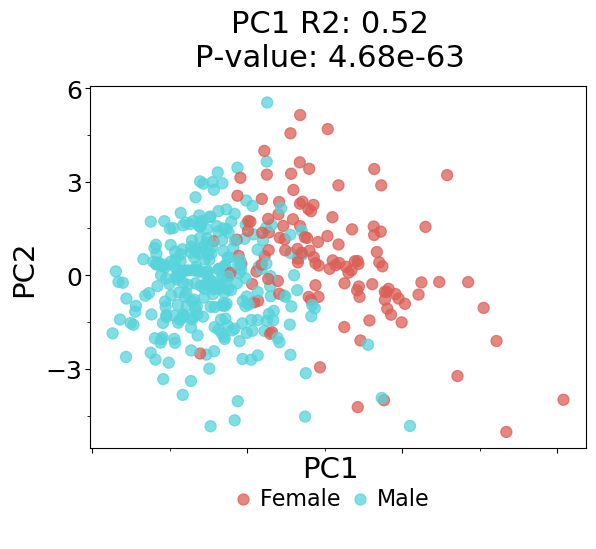

<ggplot: (8756914451122)>

In [12]:
genes_plot = plot_corr('../../../_m/genes/residualized_expression.tsv', gg)
genes_plot

## Transcripts

### Summary

In [10]:
ml_file = '../../_m/transcripts/autosomal_chrom/raffe_genes_10folds.txt'
ml_trans = pd.read_csv(ml_file, sep='\t')
ml_trans['fold'] = ml_trans['fold'].astype('str')
ml_trans['Type'] = 'Transcripts'

In [11]:
trans_df = ml_trans[['fold', 'n_features', 'test_score_accuracy', 'test_score_nmi', 'test_score_roc', 'Type']]
trans_df.median()

fold                    4.500000
n_features             28.000000
test_score_accuracy     0.857143
test_score_nmi          0.406986
test_score_roc          0.803636
dtype: float64

In [15]:
tt0 = extract_ml('transcripts')
tt0 = tt0[(tt0['Rank'] <= 28)]

tt = pd.DataFrame({'Geneid': tt0.Geneid, 'Rank': tt0.Rank})\
       .merge(pd.read_csv('../../_m/transcripts/autosomal_chrom/important_features.txt', 
                          sep='\t', header=None, index_col=False, 
                          names=['feature_importance', 'Geneid', 'Fold', 'transcript_id', 
                                 'gene_id', 'gene_name', 'gene_type', 'chrom', 'ensemblID'])\
                .groupby('Geneid').first().reset_index().drop(['Fold', 'feature_importance'], axis=1), 
              on='Geneid').set_index('transcript_id')
tt.head(2)

,Geneid,Rank,gene_id,gene_name,gene_type,chrom,ensemblID
transcript_id,,,,,,,
ENST00000550058.1,ENST00000550058.1,1.0,ENSG00000127720.7,METTL25,protein_coding,chr12,ENSG00000127720
ENST00000609745.1,ENST00000609745.1,2.0,ENSG00000234684.6,SDCBP2-AS1,antisense,chr20,ENSG00000234684


In [16]:
tt.to_csv('transcripts_top_features.txt', sep='\t', index=True, header=True)

### PCA plot

Explained Variance
PC1:	0.05827
PC2:	0.04630
PC2 R2: 0.0016 Pval: 4.374e-01


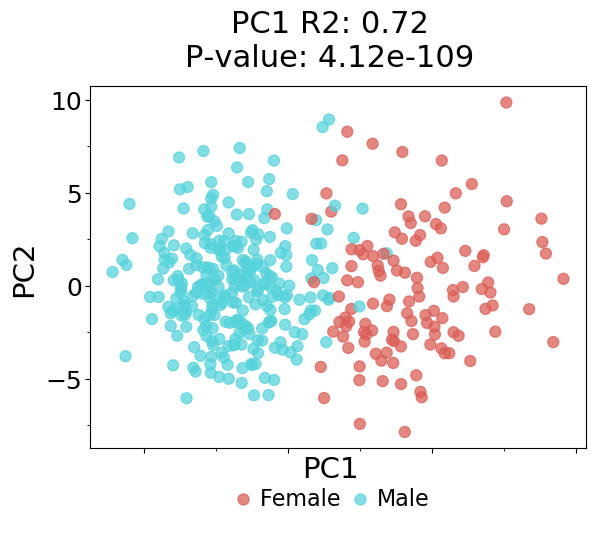

<ggplot: (8756914410668)>

In [17]:
trans_plot = plot_corr('../../../_m/transcripts/residualized_expression.tsv', tt)
trans_plot

### Exons

In [12]:
ml_file = '../../_m/exons/autosomal_chrom/raffe_genes_10folds.txt'
ml_exons = pd.read_csv(ml_file, sep='\t')
ml_exons['fold'] = ml_exons['fold'].astype('str')
ml_exons['Type'] = 'Exons'

In [13]:
exons_df = ml_exons[['fold', 'n_features', 'test_score_accuracy', 'test_score_nmi', 'test_score_roc', 'Type']]
exons_df.median()

fold                    4.500000
n_features             17.000000
test_score_accuracy     0.842857
test_score_nmi          0.322667
test_score_roc          0.796402
dtype: float64

In [23]:
ee0 = extract_ml('exons')
ee0 = ee0[(ee0['Rank'] <= 17)]

ee = pd.DataFrame({'Geneid': ee0.Geneid, 'Rank': ee0.Rank})\
       .merge(pd.read_csv('../../_m/exons/autosomal_chrom/important_features.txt', 
                          sep='\t', header=None, index_col=False,
                          names=['feature_importance', 'Geneid', 'Fold', 'exon_id', 
                                 'gene_id', 'gene_name', 'gene_type', 'chrom', 
                                 'start', 'end', 'ensemblID'])\
                .groupby('Geneid').first().reset_index().drop(['Fold', 'feature_importance'], axis=1), 
              on='Geneid').set_index('exon_id')
ee.head(2)

In [21]:
ee.to_csv('exons_top_features.txt', sep='\t', index=True, header=True)

### PCA plot

Explained Variance
PC1:	0.32916
PC2:	0.09590
PC2 R2: 0.2097 Pval: 1.298e-21


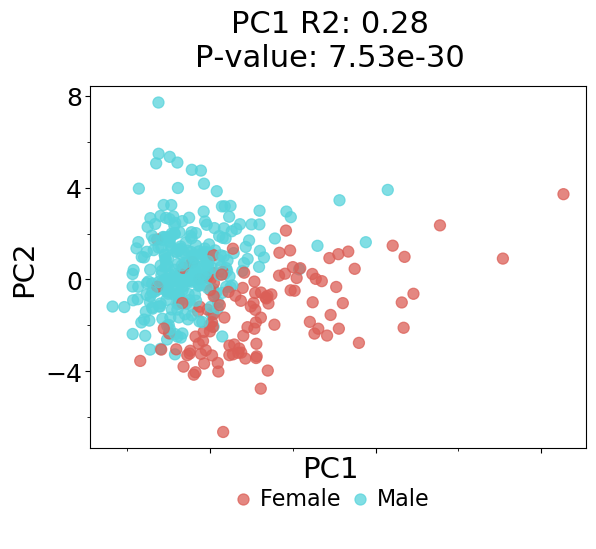

<ggplot: (8756897926051)>

In [29]:
exons_plot = plot_corr('../../../_m/exons/residualized_expression.tsv', ee)
exons_plot

### Junctions

In [14]:
ml_file = '../../_m/junctions/autosomal_chrom/raffe_genes_10folds.txt'
ml_juncs = pd.read_csv(ml_file, sep='\t')
ml_juncs['fold'] = ml_juncs['fold'].astype('str')
ml_juncs['Type'] = 'Junctions'

In [15]:
juncs_df = ml_juncs[['fold', 'n_features', 'test_score_accuracy', 'test_score_nmi', 'test_score_roc', 'Type']]
juncs_df.median()

fold                    4.500000
n_features             43.000000
test_score_accuracy     0.800000
test_score_nmi          0.222218
test_score_roc          0.756932
dtype: float64

In [30]:
jj0 = extract_ml('junctions')
jj0 = jj0[(jj0['Rank'] <= 43)]

jj = pd.DataFrame({'Geneid': jj0.Geneid, 'Rank': jj0.Rank})\
       .merge(pd.read_csv('../../_m/junctions/autosomal_chrom/important_features.txt', 
                          sep='\t', header=None, index_col=False,
                          names=['feature_importance', 'Geneid', 'Fold', 
                                 'junction_id', 'gene_id', 'gene_name', 
                                 'chrom', 'start', 'end', 'ensemblID'])\
                .groupby('Geneid').first().reset_index().drop(['Fold', 'feature_importance'], axis=1), 
              on='Geneid').set_index('junction_id')
jj.head(2)

In [28]:
jj.to_csv('junctions_top_features.txt', sep='\t', index=True, header=True)

### PCA plot

Explained Variance
PC1:	0.26371
PC2:	0.10665
PC2 R2: 0.1083 Pval: 2.652e-11


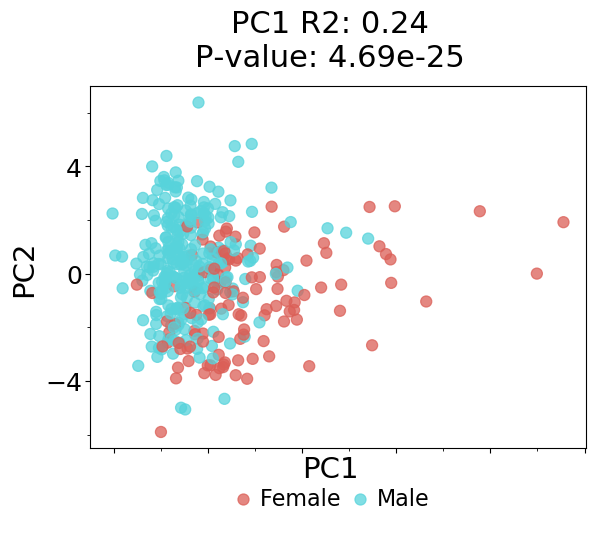

<ggplot: (8756891097263)>

In [36]:
juncs_plot = plot_corr('../../../_m/junctions/residualized_expression.tsv', jj)
juncs_plot

## Save Plots

In [ ]:
save_plot(genes_plot, 'gene_pca_raffe')
save_plot(trans_plot, 'transcript_pca_raffe')
save_plot(exons_plot, 'exon_pca_raffe')
save_plot(juncs_plot, 'junction_pca_raffe')

## Output merged dataset

In [39]:
ml_df2 = pd.concat([genes_df, trans_df, exons_df, juncs_df])
ml_df2.loc[:, 'Type'] = ml_df2.Type.astype('category').cat\
                              .reorder_categories(['Genes', 'Transcripts', 'Exons', 'Junctions'])
ml_df2.to_csv('metrics_by_feature.txt', sep='\t', index=False, header=True)
ml_df2.shape

In [40]:
print("Mean:\n=====\n", ml_df2.groupby('Type').mean())
print("\nMedian:\n=======\n", ml_df2.groupby('Type').median())
print("\nStd:\n====\n", ml_df2.groupby('Type').std())

Mean:
=====
              n_features  test_score_accuracy  test_score_nmi  test_score_roc
Type                                                                        
Genes              38.8             0.892308        0.507374        0.847210
Transcripts       343.9             0.984615        0.914224        0.975000
Exons              61.2             0.843590        0.359812        0.788185
Junctions          56.8             0.784615        0.198532        0.717947

Median:
              n_features  test_score_accuracy  test_score_nmi  test_score_roc
Type                                                                        
Genes              38.0             0.884615        0.482029        0.835648
Transcripts       241.5             1.000000        1.000000        1.000000
Exons              38.0             0.846154        0.335704        0.775463
Junctions          33.5             0.782051        0.177781        0.712963

Std:
====
              n_features  test_score_accur

### Summary statistics

In [63]:
feat_ml = {
    'Genes': set(gg['Geneid']),
    'Transcripts': set(tt['gene_id']),
    'Exons': set(ee['gene_id']),
    'Junctions': set(jj['gene_id']),
}
def limiting_features(f1, f2):
    xx = len(feat_ml[f1] & feat_ml[f2]) / len(feat_ml[f2]) * 100
    print("Comparing %s with %s: %0.2f%%" % (f1, f2, xx))
    print("Features in common: %d" % len(feat_ml[f1] & feat_ml[f2]))

#### Unique features

In [60]:
print("There are %d unique %s!" % (len(set(gg['Geneid'])), 'Genes'))
print("There are %d unique %s!" % (len(set(tt['Geneid'])), 'Transcripts'))
print("There are %d unique %s!" % (len(set(ee['Geneid'])), 'Exons'))
print("There are %d unique %s!" % (len(set(jj['Geneid'])), 'Junctions'))

There are 38 unique Genes!
There are 190 unique Transcripts!
There are 38 unique Exons!
There are 34 unique Junctions!


#### Unique known genes

In [62]:
print("There are %d unique %s!" % (len(set(gg['ensemblID'])), 'Genes'))
print("There are %d unique %s!" % (len(set(tt['ensemblID'])), 'Transcripts'))
print("There are %d unique %s!" % (len(set(ee['ensemblID'])), 'Exons'))
print("There are %d unique %s!" % (len(set(jj['ensemblID'])), 'Junctions'))

There are 38 unique Genes!
There are 181 unique Transcripts!
There are 21 unique Exons!
There are 18 unique Junctions!


#### Percent overlap

In [64]:
limiting_features('Genes', 'Transcripts')
limiting_features('Genes', 'Exons')
limiting_features('Genes', 'Junctions')

Comparing Genes with Transcripts: 9.39%
Features in common: 17
Comparing Genes with Exons: 80.95%
Features in common: 17
Comparing Genes with Junctions: 33.33%
Features in common: 6


In [65]:
limiting_features('Transcripts', 'Exons')
limiting_features('Transcripts', 'Junctions')
limiting_features('Junctions', 'Exons')

Comparing Transcripts with Exons: 71.43%
Features in common: 15
Comparing Transcripts with Junctions: 44.44%
Features in common: 8
Comparing Junctions with Exons: 28.57%
Features in common: 6


## Feature comparison

In [50]:
def extract_features(ml_df, num=10):
    markers = [k for k, v in Counter(ml_df.Geneid).most_common()]
    num_size = [v for k, v in Counter(ml_df.Geneid).most_common()]
    features = pd.DataFrame({'Geneid': markers, 'Count': num_size})
    feat = features[(features['Count'] >= num)].drop('Count', axis=1)
    ml = ml_df.sort_values('feature_importance', ascending=False)\
              .groupby(['Geneid']).first().reset_index()
    dft = feat.merge(ml, on='Geneid').drop(['Fold'], axis=1)
    return dft

### Features in all 10 folds

In [51]:
ml_file = '../../_m/genes/autosomal_chrom/important_features.txt'
ml_df = pd.read_csv(ml_file, sep='\t', header=None, 
                    names=['feature_importance', 'Geneid', 
                           'Fold', 'gene_id', 'gene_name', 
                           'gene_type', 'chrom', 'ensemblID'])
genes_ml = extract_features(ml_df, num=10)
print("There are %d %s in all 10 folds!" % (genes_ml.shape[0], 'Genes'))
genes_ml

There are 11 Genes in all 10 folds!


,Geneid,feature_importance,gene_id,gene_name,gene_type,chrom,ensemblID
0,ENSG00000205611.4,0.130598,ENSG00000205611.4,LINC01597,lincRNA,chr20,ENSG00000205611
1,ENSG00000283443.1,0.093850,ENSG00000283443.1,RP11-462H3.2,unprocessed_pseudogene,chr20,ENSG00000283443
2,ENSG00000149531.15,0.092671,ENSG00000149531.15,FRG1BP,unprocessed_pseudogene,chr20,ENSG00000149531
3,ENSG00000095932.6,0.064853,ENSG00000095932.6,SMIM24,protein_coding,chr19,ENSG00000095932
4,ENSG00000241532.1,0.064662,ENSG00000241532.1,AGGF1P3,processed_pseudogene,chr3,ENSG00000241532
5,ENSG00000261600.1,0.067215,ENSG00000261600.1,RP11-575H3.1,lincRNA,chr2,ENSG00000261600
6,ENSG00000172460.14,0.056535,ENSG00000172460.14,PRSS30P,unitary_pseudogene,chr16,ENSG00000172460
7,ENSG00000258484.3,0.058101,ENSG00000258484.3,SPESP1,protein_coding,chr15,ENSG00000258484
8,ENSG00000182912.6,0.070392,ENSG00000182912.6,TSPEAR-AS2,antisense,chr21,ENSG00000182912
9,ENSG00000080007.7,0.073670,ENSG00000080007.7,DDX43,protein_coding,chr6,ENSG00000080007


In [52]:
ml_file = '../../_m/transcripts/autosomal_chrom/important_features.txt'
ml_df = pd.read_csv(ml_file, sep='\t', header=None, 
                    names=['feature_importance', 'Geneid', 'Fold', 'transcript_id', 
                           'gene_id', 'gene_name', 'gene_type', 'chrom', 'ensemblID'])
trans_ml = extract_features(ml_df, num=10)
print("There are %d %s in all 10 folds!" % (trans_ml.shape[0], 'Transcripts'))
trans_ml

There are 21 Transcripts in all 10 folds!


,Geneid,feature_importance,transcript_id,gene_id,gene_name,gene_type,chrom,ensemblID
0,ENST00000550058.1,0.254847,ENST00000550058.1,ENSG00000127720.7,METTL25,protein_coding,chr12,ENSG00000127720
1,ENST00000474345.5,0.126515,ENST00000474345.5,ENSG00000160752.14,FDPS,protein_coding,chr1,ENSG00000160752
2,ENST00000609745.1,0.131849,ENST00000609745.1,ENSG00000234684.6,SDCBP2-AS1,antisense,chr20,ENSG00000234684
3,ENST00000636528.1,0.041796,ENST00000636528.1,ENSG00000283443.1,RP11-462H3.2,unprocessed_pseudogene,chr20,ENSG00000283443
4,ENST00000570562.5,0.038173,ENST00000570562.5,ENSG00000215067.9,ALOX12-AS1,antisense,chr17,ENSG00000215067
5,ENST00000414784.1,0.031175,ENST00000414784.1,ENSG00000243389.1,AC012442.5,3prime_overlapping_ncRNA,chr2,ENSG00000243389
6,ENST00000278882.8,0.020871,ENST00000278882.8,ENSG00000149531.15,FRG1BP,unprocessed_pseudogene,chr20,ENSG00000149531
7,ENST00000421320.1,0.020552,ENST00000421320.1,ENSG00000234944.1,RP11-124O11.1,lincRNA,chr10,ENSG00000234944
8,ENST00000380888.4,0.031460,ENST00000380888.4,ENSG00000205611.4,LINC01597,lincRNA,chr20,ENSG00000205611
9,ENST00000572385.5,0.028594,ENST00000572385.5,ENSG00000215067.9,ALOX12-AS1,antisense,chr17,ENSG00000215067


In [54]:
ml_file = '../../_m/exons/autosomal_chrom/important_features.txt'
ml_df = pd.read_csv(ml_file, sep='\t', header=None, 
                    names=['feature_importance', 'Geneid', 'Fold', 
                           'exon_id', 'gene_id', 'gene_name', 'gene_type', 
                           'chrom', 'start', 'end', 'ensemblID'])
exons_ml = extract_features(ml_df, num=10)
print("There are %d %s in all 10 folds!" % (exons_ml.shape[0], 'Exons'))
exons_ml

There are 3 Exons in all 10 folds!


,Geneid,feature_importance,exon_id,gene_id,gene_name,gene_type,chrom,start,end,ensemblID
0,e1085151,0.187516,e1085151,ENSG00000205611.4,LINC01597,lincRNA,chr20,30278906,30282135,ENSG00000205611
1,e1085161,0.144090,e1085161,ENSG00000149531.15,FRG1BP,unprocessed_pseudogene,chr20,30377372,30377437,ENSG00000149531
2,e1085165,0.169065,e1085165,ENSG00000149531.15,FRG1BP,unprocessed_pseudogene,chr20,30391197,30391308,ENSG00000149531


In [53]:
ml_file = '../../_m/junctions/autosomal_chrom/important_features.txt'
ml_df = pd.read_csv(ml_file, sep='\t', header=None, 
                    names=['feature_importance', 'Geneid', 'Fold', 
                           'junction_id', 'gene_id', 'gene_name', 
                           'chrom', 'start', 'end', 'ensemblID'])
juncs_ml = extract_features(ml_df, num=10)
print("There are %d %s in all 10 folds!" % (juncs_ml.shape[0], 'Junctions'))
juncs_ml

There are 1 Junctions in all 10 folds!


,Geneid,feature_importance,junction_id,gene_id,gene_name,chrom,start,end,ensemblID
0,chr20:30391309-30393550(+),0.36523,chr20:30391309-30393550(+),ENSG00000149531.15,FRG1BP,chr20,30391309,30393550,ENSG00000149531
